In [5]:
import pymc
import pandas as pd
import sqlite3


In [6]:
print(f'PyMC version: {pymc.__version__}')

PyMC version: 5.10.4


Ingestion of tweets.csv into SQLite Database  

In [7]:
import pandas as pd
import sqlite3

def create_sqlite_table_from_csv(csv_file):
    
    df = pd.read_csv(csv_file)


    conn = sqlite3.connect('database.sqlite')
    cursor = conn.cursor()

    # Iterate over each column in the DataFrame
    for column_name in df.columns:
        # Get the column data type
        column_dtype = df[column_name].dtype

        # Create SQL table with the column name as table name and column data type
        create_table_sql = f"CREATE TABLE IF NOT EXISTS {column_name} ({column_name} {column_dtype})"

        
        cursor.execute(create_table_sql)
        
        # Insert data into the table
        for index, row in df.iterrows():
            # Insert data into the table
            insert_sql = f"INSERT INTO {column_name} ({column_name}) VALUES (?)"
            cursor.execute(insert_sql, (row[column_name],))
    
    print("Database and table successfully created and populated.")

    # Commit changes and close the connection
    conn.commit()
    conn.close()


db = create_sqlite_table_from_csv('Tweets.csv')
db

Database and table successfully created and populated.


In [8]:
db_connect = sqlite3.connect('database.sqlite')

tweets = pd.read_sql_query("SELECT * FROM Tweets", db_connect)
display(tweets)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0000,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0000,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0000,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",
3,567592368451248130,negative,1.0000,Late Flight,1,United,,brenduch,,0,@united the we got into the gate at IAH on tim...,,2015-02-16 23:52:20 -0800,,Buenos Aires
4,567594449874587648,negative,1.0000,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14480,570309308937842688,neutral,0.6869,,,Delta,,Oneladyyouadore,,0,@JetBlue I hope so because I fly very often an...,,2015-02-24 11:48:29 -0800,Georgia,Quito
14481,570309340952993796,neutral,1.0000,,,US Airways,,DebbiMcGinnis,,0,@USAirways is a DM possible if you aren't foll...,,2015-02-24 11:48:37 -0800,Missourah,Hawaii
14482,570309345281486848,positive,0.6469,,,Delta,,jaxbra,,0,@JetBlue Yesterday on my way from EWR to FLL j...,,2015-02-24 11:48:38 -0800,"east brunswick, nj",Atlantic Time (Canada)
14483,570310144459972608,negative,1.0000,Customer Service Issue,1,US Airways,,GAKotsch,,0,@USAirways and when will one of these agents b...,,2015-02-24 11:51:48 -0800,,Atlantic Time (Canada)


In [9]:
print("Dataframe data type:", tweets.dtypes)

Dataframe data type: tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence        object
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object


In [10]:
print("Uniques:", tweets.nunique())

Uniques: tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1018
negativereason                     11
negativereason_confidence        1404
airline                             6
airline_sentiment_gold              4
name                             7701
negativereason_gold                14
retweet_count                      18
text                            14427
tweet_coord                       833
tweet_created                   14247
tweet_location                   3082
user_timezone                      86
dtype: int64


In [11]:
print("Summary Statistics:\n", tweets.describe())

Summary Statistics:
            tweet_id  airline_sentiment_confidence  retweet_count
count  1.448500e+04                  14485.000000   14485.000000
mean   5.692072e+17                      0.899958       0.083397
std    7.756739e+14                      0.162961       0.749632
min    5.675883e+17                      0.335000       0.000000
25%    5.685515e+17                      0.692300       0.000000
50%    5.694398e+17                      1.000000       0.000000
75%    5.698811e+17                      1.000000       0.000000
max    5.703106e+17                      1.000000      44.000000


In [12]:
sentiment = tweets['text'].value_counts()
sentiment

text
@united thanks                                                                                                                      6
@SouthwestAir sent                                                                                                                  5
@JetBlue thanks!                                                                                                                    5
@united thank you!                                                                                                                  4
@AmericanAir thanks                                                                                                                 4
                                                                                                                                   ..
@USAirways Batting 1.000! Four flights in a month, all four delayed!                                                                1
@JetBlue before departure, while people who are delayed g

In [13]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Example preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    return text

documents = [preprocess_text(doc) for doc in tweets['text']]
text  =  tweets['airline_sentiment']
vectorizer = CountVectorizer(binary=True)

# Fit and transform the text data
X = vectorizer.fit_transform(text)

# Convert to array to see the one-hot encoded result
one_hot_encoded_result = X.toarray()

# Getting feature names
feature_names = vectorizer.get_feature_names_out()

# Display results
print("Feature names:", feature_names)
print("One-hot encoded data:\n", one_hot_encoded_result)

encoded_sentiment = pd.DataFrame(one_hot_encoded_result, columns=feature_names)
tweets = pd.concat([tweets, encoded_sentiment], axis = 1)
# tweets.drop(tweets.columns[[-1, -2, -3]], axis = 1, inplace = True)
tweets

Feature names: ['negative' 'neutral' 'positive']
One-hot encoded data:
 [[0 1 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [1 0 0]
 [1 0 0]]


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,negative,neutral,positive
0,567588278875213824,neutral,1.0000,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney,0,1,0
1,567590027375702016,negative,1.0000,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada),1,0,0
2,567591480085463040,negative,1.0000,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",,1,0,0
3,567592368451248130,negative,1.0000,Late Flight,1,United,,brenduch,,0,@united the we got into the gate at IAH on tim...,,2015-02-16 23:52:20 -0800,,Buenos Aires,1,0,0
4,567594449874587648,negative,1.0000,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada),1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14480,570309308937842688,neutral,0.6869,,,Delta,,Oneladyyouadore,,0,@JetBlue I hope so because I fly very often an...,,2015-02-24 11:48:29 -0800,Georgia,Quito,0,1,0
14481,570309340952993796,neutral,1.0000,,,US Airways,,DebbiMcGinnis,,0,@USAirways is a DM possible if you aren't foll...,,2015-02-24 11:48:37 -0800,Missourah,Hawaii,0,1,0
14482,570309345281486848,positive,0.6469,,,Delta,,jaxbra,,0,@JetBlue Yesterday on my way from EWR to FLL j...,,2015-02-24 11:48:38 -0800,"east brunswick, nj",Atlantic Time (Canada),0,0,1
14483,570310144459972608,negative,1.0000,Customer Service Issue,1,US Airways,,GAKotsch,,0,@USAirways and when will one of these agents b...,,2015-02-24 11:51:48 -0800,,Atlantic Time (Canada),1,0,0


In [14]:
# X_dense = X.toarray()
X = one_hot_encoded_result
# y = feature_names

y_binary = (tweets['airline_sentiment'] != 0).astype(int) 

with pymc.Model() as model:
    # Priors
    intercept = pymc.Normal('Intercept', mu=0, sigma=10)
    beta = pymc.Normal('beta', mu=0, sigma=10, shape=X.shape[1])
    
    # Logistic function for probability
    logits = intercept + pymc.math.dot(X, beta)
    
    # Likelihood
    observed = pymc.Bernoulli('obs', logit_p=logits, observed=y_binary)
    
    # Sampling
    trace = pymc.sample(500, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2511 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


In [35]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(documents)
print(tfidf_matrix)

  (0, 11689)	0.10345039504266204
  (0, 1852)	0.21491397301349446
  (0, 18292)	0.21259024403826995
  (0, 18859)	0.24680791166094745
  (0, 24997)	0.24338853891982354
  (0, 3077)	0.24680791166094745
  (0, 20176)	0.24680791166094745
  (0, 23598)	0.21491397301349446
  (0, 20745)	0.24680791166094745
  (0, 4769)	0.24680791166094745
  (0, 16135)	0.2403298057735481
  (0, 13247)	0.24338853891982354
  (0, 5191)	0.10215312550516377
  (0, 11688)	0.10345039504266204
  (0, 5943)	0.22326570406856286
  (0, 27312)	0.20656224195842607
  (0, 1485)	0.07201089611705062
  (0, 18289)	0.1551566723832453
  (0, 18818)	0.12409821913784354
  (0, 24544)	0.05339292868022989
  (0, 3076)	0.23756284507366174
  (0, 20169)	0.1522217394844879
  (0, 23141)	0.06148760251400916
  (0, 20744)	0.24680791166094745
  (0, 4764)	0.19303113785213116
  :	:
  (14484, 12661)	0.1450571791952457
  (14484, 14767)	0.1614184938474595
  (14484, 16025)	0.10976750433425855
  (14484, 15751)	0.11260837361482946
  (14484, 8320)	0.1464353913376525

array([[<Axes: ylabel='beta\n0'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta\n1'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='Intercept', ylabel='beta\n2'>,
        <Axes: xlabel='beta\n0'>, <Axes: xlabel='beta\n1'>]], dtype=object)

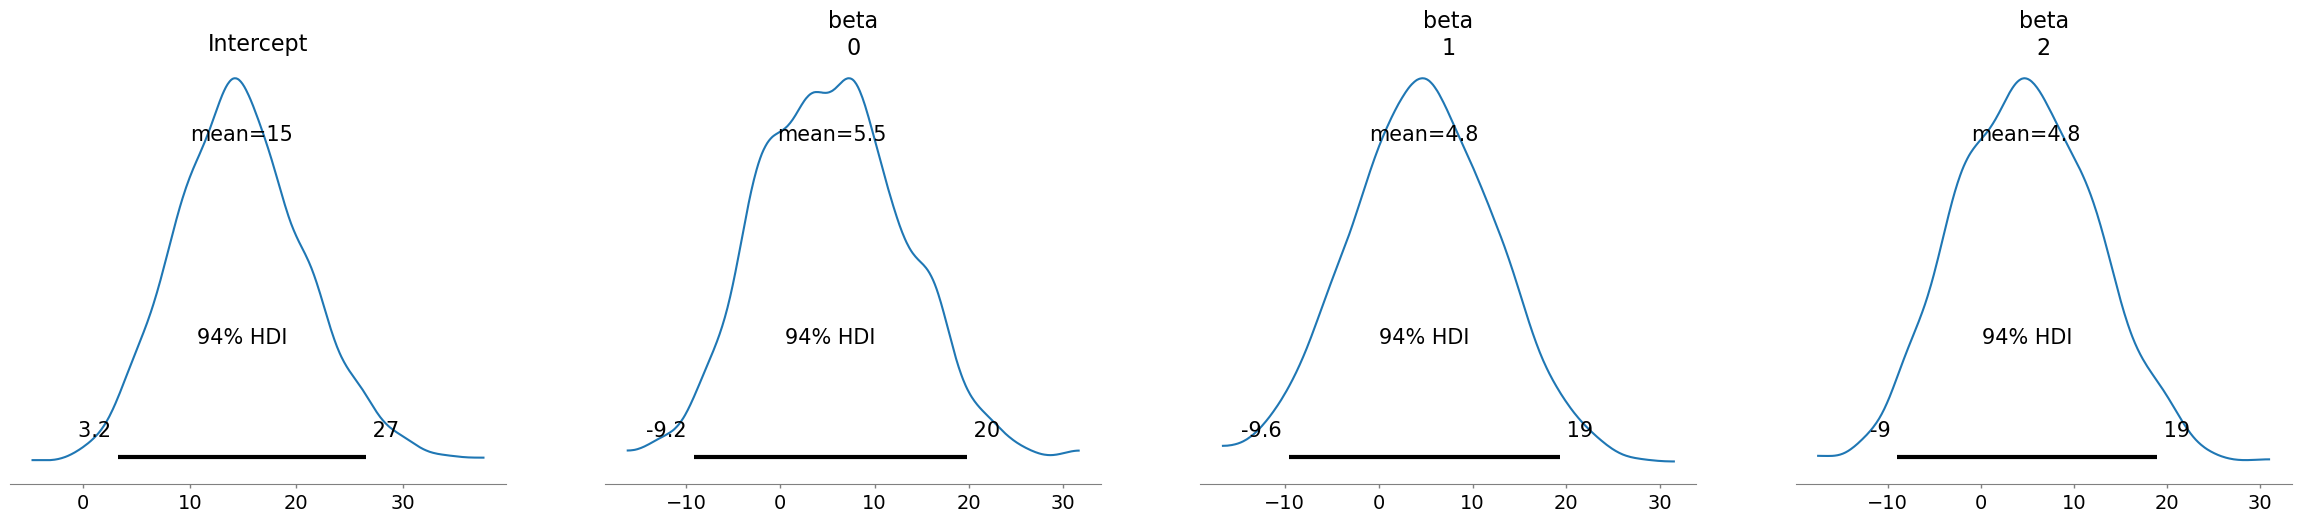

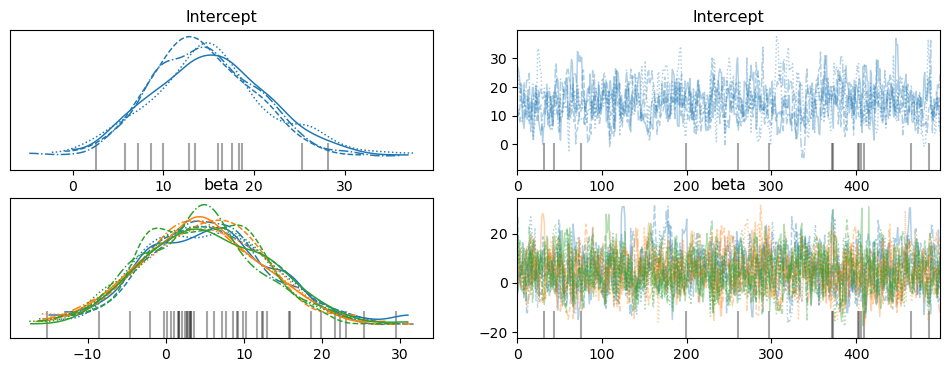

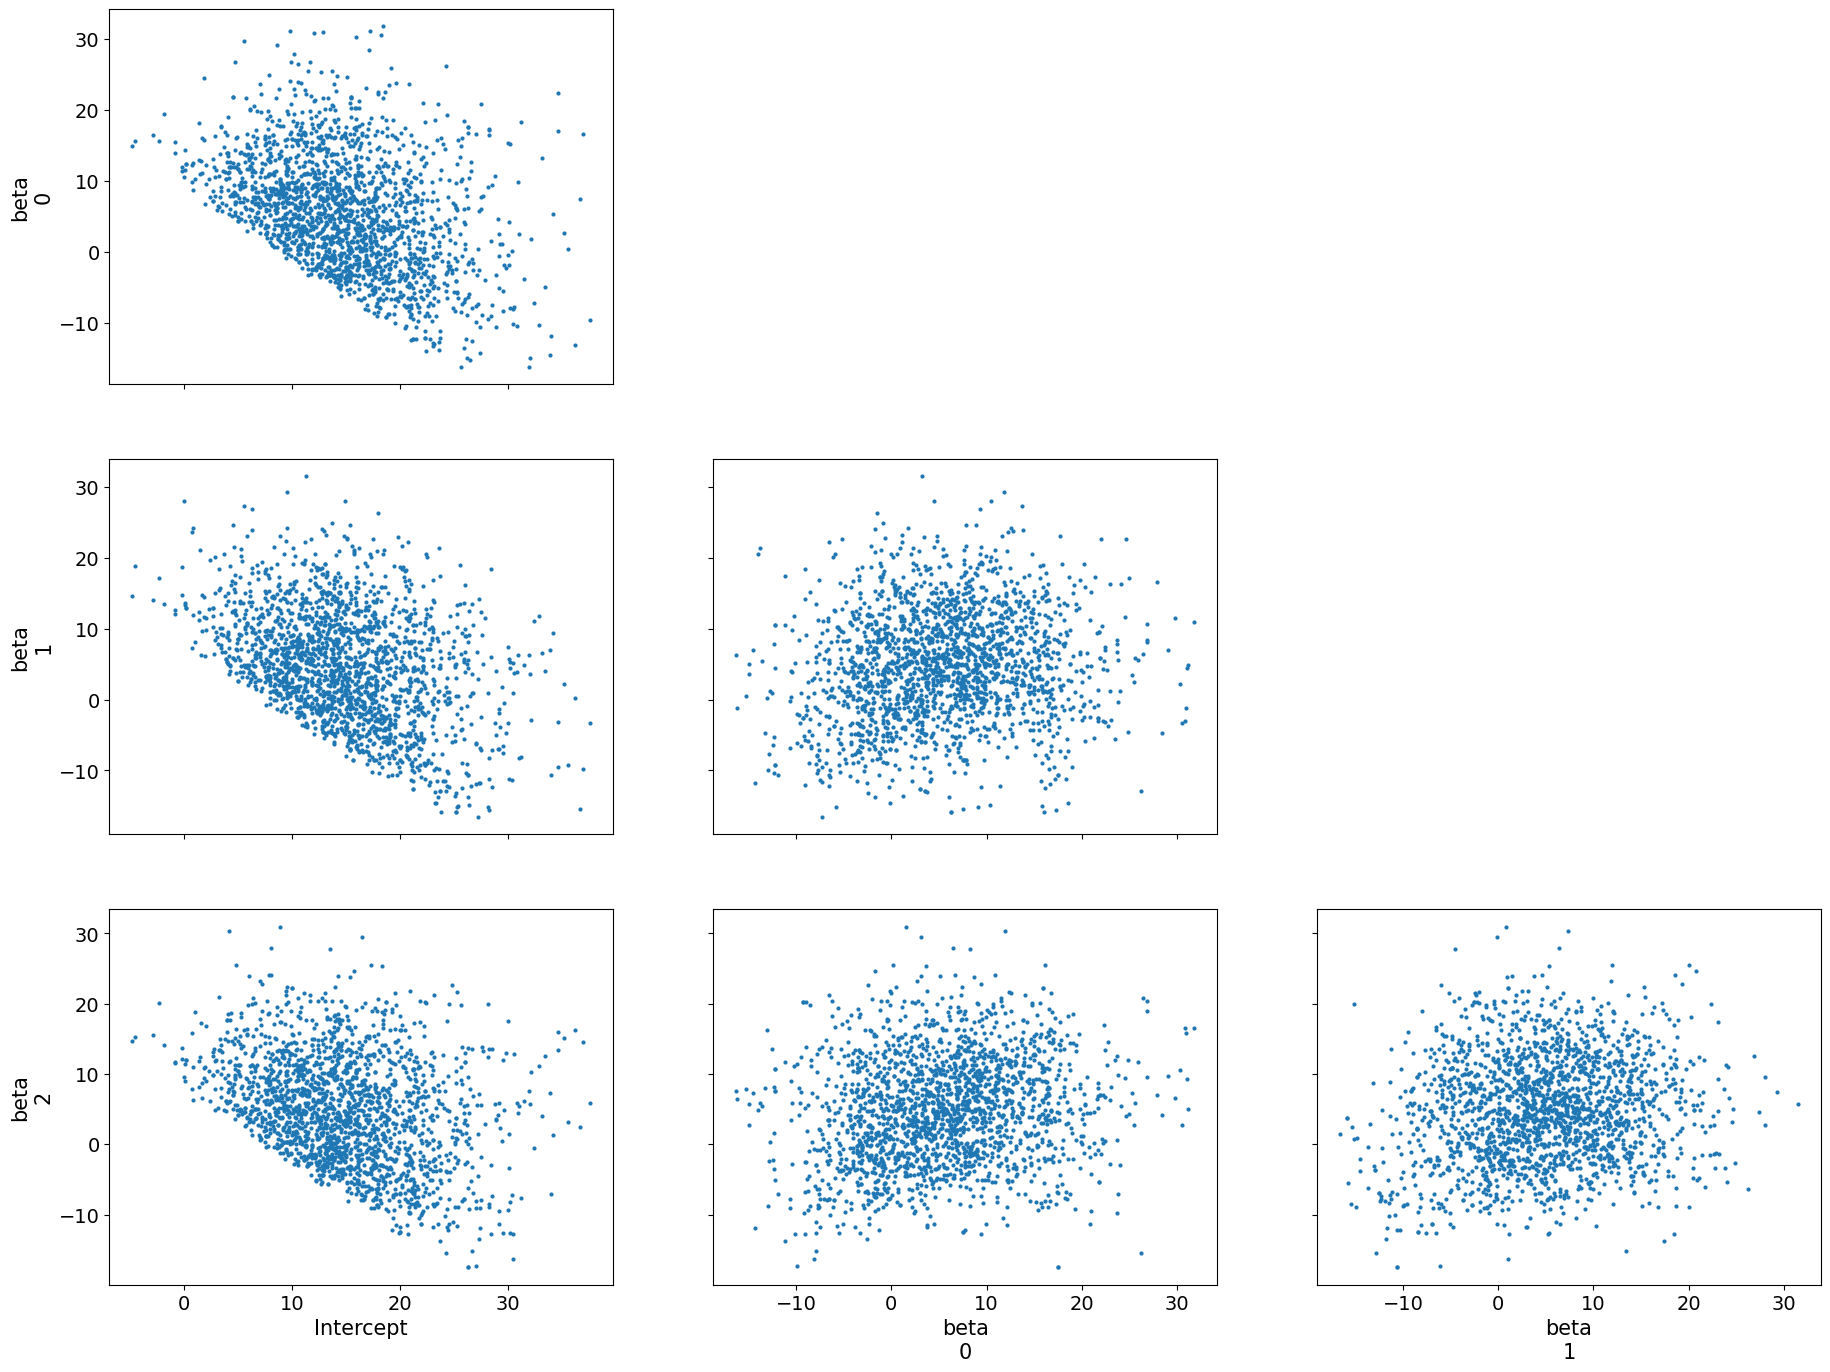

In [19]:
import arviz as az
# print(trace)
az.plot_posterior(trace)
az.plot_trace(trace)
az.summary(trace, round_to=2)
az.plot_pair(trace, var_names=['Intercept', 'beta'])


Sampling: [obs]


<Axes: xlabel='obs'>

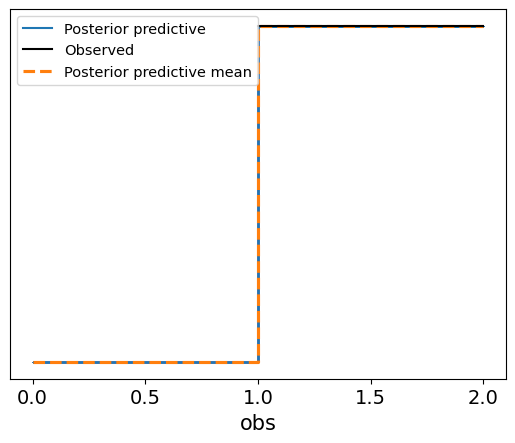

In [22]:
with model:
    ppc = pymc.sample_posterior_predictive(trace)

# Directly using the ppc output if it's already compatible with ArviZ's data structures
az.plot_ppc(ppc)
# az.plot_ppc(az.InferenceData(posterior_predictive=ppc))



In [17]:
with model:
    ppc = pymc.sample_posterior_predictive(trace)

# Using ArviZ to plot posterior predictive checks
az.plot_ppc(az.from_pymc(trace, posterior_predictive=ppc))


Sampling: [obs]


AttributeError: module 'arviz' has no attribute 'from_pymc'

In [39]:
# Example calculation
import numpy as np
num_docs_containing_aviation = 10  # Hypothetical number of documents containing "aviation"
total_num_docs = 100  # Total number of documents in the corpus
idf_aviation = np.log(total_num_docs / (1 + num_docs_containing_aviation))
print(idf_aviation)

2.207274913189721


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit the model and transform the documents into TF-IDF vectors
tfidf_matrix = vectorizer.fit_transform(tweets['text'])
print(tfidf_matrix)

feature_names = vectorizer.get_feature_names_out()
print(feature_names)
# View the IDF values
idf_values = vectorizer.idf_

# Create a mapping of feature names to their IDF values
idf_dict = dict(zip(feature_names, idf_values))

print("Feature Names:", feature_names)
print("IDF Values:", idf_values)

  (0, 8417)	0.3651117882177565
  (0, 3944)	0.1299315275847306
  (0, 7187)	0.1315815623914264
  (0, 11263)	0.3651117882177565
  (0, 4525)	0.2839781342318535
  (0, 6667)	0.3651117882177565
  (0, 14399)	0.2627325155864011
  (0, 2281)	0.09159275048085305
  (0, 10132)	0.19734827845966965
  (0, 10410)	0.15784412961803687
  (0, 13326)	0.06791791695820322
  (0, 2787)	0.3021630831670956
  (0, 11438)	0.19361525205437424
  (0, 13120)	0.07820786767570888
  (0, 11857)	0.3139221519020788
  (0, 3646)	0.2455219112339181
  (0, 9429)	0.18551785604600257
  (0, 7804)	0.10582167682759647
  (1, 9620)	0.5095421044898925
  (1, 9405)	0.6399488826454467
  (1, 9248)	0.1713259321836739
  (1, 9815)	0.15892936477931
  (1, 6485)	0.33173565673733296
  (1, 11020)	0.3167427350410727
  (1, 7658)	0.17732539283119372
  :	:
  (14483, 9755)	0.19766183640793158
  (14483, 9821)	0.28100062032526407
  (14483, 2281)	0.16277821264194978
  (14483, 13326)	0.12070340797475879
  (14484, 14753)	0.3768129636636839
  (14484, 6265)	0.327

In [27]:
# Convert the first document's TF-IDF vector to a dense array
first_document_vector = tfidf_matrix[0].toarray()

# Map each word to its TF-IDF score
tfidf_scores = {word: score for word, score in zip(feature_names, first_document_vector.flatten())}

print("TF-IDF Scores for the first document:", tfidf_scores)

TF-IDF Scores for the first document: {'00': 0.0, '000': 0.0, '000114': 0.0, '000419': 0.0, '000ft': 0.0, '000lbs': 0.0, '0011': 0.0, '0016': 0.0, '00a': 0.0, '00am': 0.0, '00p': 0.0, '00pm': 0.0, '01': 0.0, '0162389030167': 0.0, '0162424965446': 0.0, '0162431184663': 0.0, '0167560070877': 0.0, '0185': 0.0, '01ldxn3qqq': 0.0, '01pm': 0.0, '02': 0.0, '0200': 0.0, '03': 0.0, '0316': 0.0, '0372389047497': 0.0, '04': 0.0, '0400': 0.0, '04sdytt7zd': 0.0, '05': 0.0, '0510': 0.0, '0530': 0.0, '05am': 0.0, '05pm': 0.0, '06': 0.0, '0600': 0.0, '0638': 0.0, '0671': 0.0, '07': 0.0, '0736': 0.0, '0769': 0.0, '07p': 0.0, '07xhcacjax': 0.0, '08': 0.0, '0985': 0.0, '0_0': 0.0, '0bjnz4eix5': 0.0, '0cevy3p42b': 0.0, '0ewj7oklji': 0.0, '0hmmqczkcf': 0.0, '0hxlnvzknp': 0.0, '0jjt4x3yxg': 0.0, '0jutcdrljl': 0.0, '0kn7pjelzl': 0.0, '0liwecasoe': 0.0, '0pdntgbxc6': 0.0, '0prgysvurm': 0.0, '0wbjawx7xd': 0.0, '0xjared': 0.0, '10': 0.0, '100': 0.0, '1000': 0.0, '1000cost': 0.0, '1001': 0.0, '1002': 0.0, '1007'